In [ ]:
import multiprocessing as mp 
import os
from foundational_ssm.samplers import RandomVariableWindowSampler 
from foundational_ssm.constants import DATA_ROOT 
from foundational_ssm.loaders import get_brainset_data_loader

mp.set_start_method("spawn", force=True) # otherwise causes deadlock on jax.

data_root = '../' + DATA_ROOT # change to the folder holding the brainsets
config_dir = '../configs/dataset/' # change

trial_dataset, trial_loader = get_brainset_data_loader(
    dataset_args = {
        'keep_files_open': True,
        'lazy': True,
        'split': 'train',
        'recording_id' : 'perich_miller_population_2018/t_20130819_center_out_reaching',
    },
    dataloader_args={
        'batch_size': 512,
        'num_workers': 24,
        'persistent_workers': True,
    },
    sampler = 'RandomVariableWindowSampler',
    sampler_args = {
        "min_window_length": 0.880,
        "max_window_length": 1.0,
    },
    data_root = data_root,
    sampling_rate = 200
)

sessions = trial_dataset.get_session_ids() # list of sessions in your dataset
sampling_intervals = trial_dataset.get_sampling_intervals() # list of sampling intervals for each session

/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from foundational_ssm.dataset import DatasetIndex
from temporaldata import Interval
import torch
session_name = 'perich_miller_population_2018/t_20130819_center_out_reaching'
intervals = sampling_intervals[session_name]
min_window_length = 1
max_window_length = 2
prepend_history = 0.28
indices = []
for start, end in zip(intervals.start, intervals.end):

    rand_range = max_window_length - min_window_length
    interval_length = end - start
    max_samples = int(interval_length // min_window_length)
    jitter_space = interval_length - max_samples * min_window_length
    left_offset = torch.rand(1, generator=None).item() * jitter_space + start
    sample_durations = torch.rand(max_samples, generator=None) * (rand_range) + min_window_length
    sample_starts = torch.cumsum(sample_durations, dim=0) + left_offset
    sample_ends = sample_starts[sample_starts < end][1:]
    sample_starts = sample_starts[sample_starts < end][:-1]
    sample_starts = sample_starts - prepend_history
    
    for s, t in zip(sample_starts, sample_ends):
        indices.append(
            DatasetIndex(
                session_name, s, t
            )
        )

    right_offset = sample_ends[-1] if len(sample_ends) != 0 else left_offset
    if end - right_offset > min_window_length: 
        indices.append(
            DatasetIndex(
                session_name, right_offset, end
            )
        )

import numpy as np
starts = np.array([index.start for index in indices])
ends = np.array([index.end for index in indices])
samples = Interval(starts, ends)

In [ ]:
from temporaldata import Interval 
from bokeh.plotting import figure, show
from foundational_ssm.plotting import plot_intervals

fig = plot_intervals(samples, intervals)
show(fig)
samples.is_disjoint()

False

In [ ]:
print(samples.start[0],intervals.start[0])

859.687 857.22


In [ ]:
sampler = RandomVariableWindowSampler(
        sampling_intervals=sampling_intervals,
        min_window_length=1,
        max_window_length=3,
    )

for i, index in enumerate(sampler): 
    print(index)
    if i > 5:
        break


DatasetIndex(recording_id='churchland_shenoy_neural_2012/nitschke_20090920_center_out_reaching', start=np.float64(15791.785418555872), end=np.float64(15792.978129803727))
DatasetIndex(recording_id='odoherty_sabes_nonhuman_2017/indy_20170123_02', start=np.float64(1201.2341625735162), end=np.float64(1203.753065079334))
DatasetIndex(recording_id='churchland_shenoy_neural_2012/nitschke_20090920_center_out_reaching', start=np.float64(19640.580672869484), end=np.float64(19641.80972980373))
DatasetIndex(recording_id='perich_miller_population_2018/c_20150319_center_out_reaching', start=np.float64(2186.3053290241296), end=np.float64(2188.5665462723573))
DatasetIndex(recording_id='churchland_shenoy_neural_2012/nitschke_20090812_center_out_reaching', start=np.float64(10756.356189472594), end=np.float64(10759.060130381538))
DatasetIndex(recording_id='perich_miller_population_2018/m_20150623_center_out_reaching', start=np.float64(641.3681977333125), end=np.float64(642.6789061409953))
DatasetIndex(r

In [ ]:
from foundational_ssm.samplers import RandomFixedWindowSampler
sampler = RandomFixedWindowSampler(
        sampling_intervals=sampling_intervals,
        window_length=3,
        min_window_length=1.0,
    )
for i, index in enumerate(sampler):
    print(index)
    if i > 5:
        break

DatasetIndex(recording_id='perich_miller_population_2018/m_20140626_center_out_reaching', start=227.56292363243102, end=230.56292363243102)
DatasetIndex(recording_id='odoherty_sabes_nonhuman_2017/loco_20170302_02', start=4594.473515868187, end=4597.473515868187)
DatasetIndex(recording_id='odoherty_sabes_nonhuman_2017/indy_20161025_04', start=1277.7983980989457, end=1280.7983980989457)
DatasetIndex(recording_id='churchland_shenoy_neural_2012/jenkins_20090923_center_out_reaching', start=np.float64(6528.696866666667), end=np.float64(6531.696866666667))
DatasetIndex(recording_id='churchland_shenoy_neural_2012/nitschke_20090920_center_out_reaching', start=np.float64(4722.977333333333), end=np.float64(4725.977333333333))
DatasetIndex(recording_id='odoherty_sabes_nonhuman_2017/loco_20170228_02', start=5302.677274635792, end=5305.677274635792)
DatasetIndex(recording_id='churchland_shenoy_neural_2012/jenkins_20090923_center_out_reaching', start=np.float64(6687.977366666667), end=np.float64(6690

/tmp/ipykernel_275284/3779273790.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  max_value = int(np.abs(transformed_vel).max())


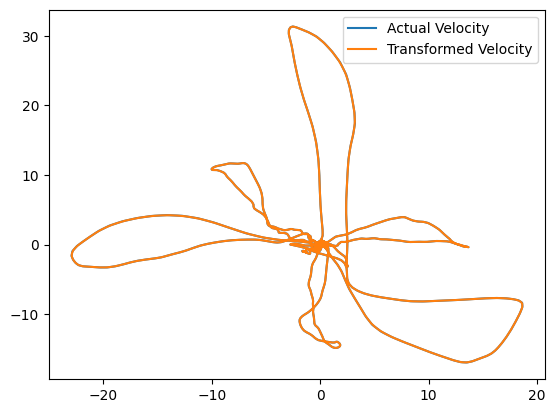

In [ ]:
# for session_id, intervals in sampling_intervals.items():
max_values = []
error_session_intervals = []
for session_id in sessions:
    if ('perich_miller_population_2018/m' in session_id) and ('center_out' in session_id):
        intervals = sampling_intervals[session_id]
        for i in range(len(intervals.start)):
            start, end = intervals.start[i], intervals.end[i]
            data = trial_dataset.get_recording_data(session_id).slice(start, end) 
            try:
                transformed_data = transform_brainsets_regular_time_series_smoothed(data)
                actual_vel = data.cursor.vel
                actual_timestamps = data.cursor.timestamps
                transformed_vel = transformed_data['behavior_input']
                max_value = int(np.abs(transformed_vel).max())
                max_values.append(max_value)
                if actual_timestamps[0] > 0.01 or max_value > 200:
                    error_session_intervals.append((session_id, start, end))
            except:
                continue
        # print("no invalid transformations found in session", session_id)

import matplotlib.pyplot as plt
plt.plot(actual_vel[:, 0], actual_vel[:, 1], label='Actual Velocity')
plt.plot(transformed_vel[:, 0], transformed_vel[:, 1], label='Transformed Velocity')
plt.legend()

Text(0.5, 0.98, 'Outlier Segments for Perich Miller Task')

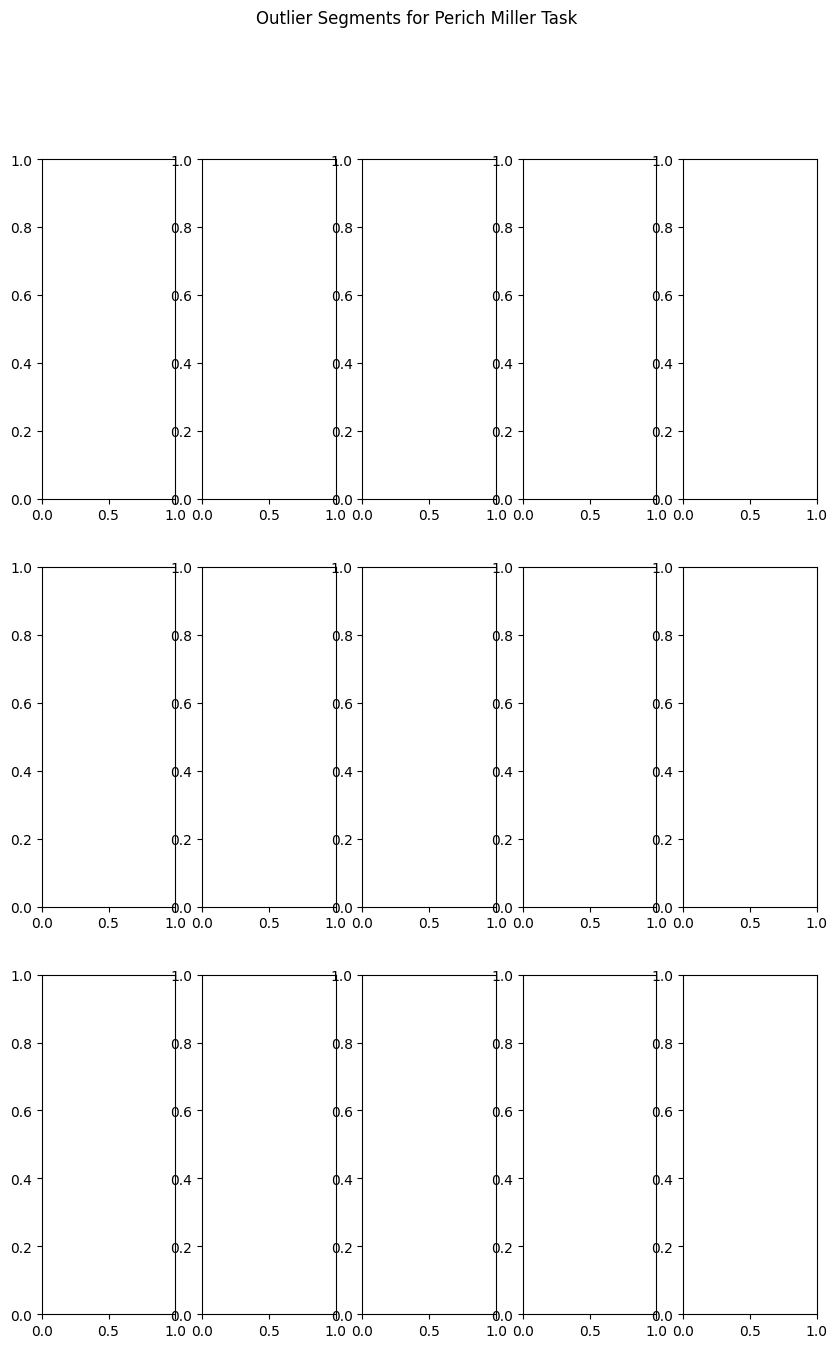

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(10, 15))
axs = axs.flatten()
for i, (session_id, start, end) in enumerate(error_session_intervals[:15]):
    data = train_dataset.get_recording_data(session_id).slice(start, end)
    actual_vel = data.cursor.vel
    transformed = transform_brainsets_regular_time_series_smoothed(data)
    transformed = {k: jax.device_put(np.array(v)) for k, v in transformed.items()}
    transformed_vel = transformed['behavior_input']
    transformed_spikes = transformed['neural_input']
    pred, state = inf_model(transformed_spikes, state, 0, jr.PRNGKey(0))
    # axs[i].plot(actual_vel[:, 0], actual_vel[:, 1], label='Actual Velocity', color='grey')
    axs[i].plot(transformed_vel[:, 0], transformed_vel[:, 1], label='Target', color='blue', linestyle='--')
    axs[i].plot(pred[:, 0], pred[:, 1], label='Preds', color='green')
    # axs[i].set_title(f"Session {session_id}")
    axs[i].legend()
    
plt.suptitle("Outlier Segments for Perich Miller Task")

/tmp/ipykernel_266634/3869812628.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}


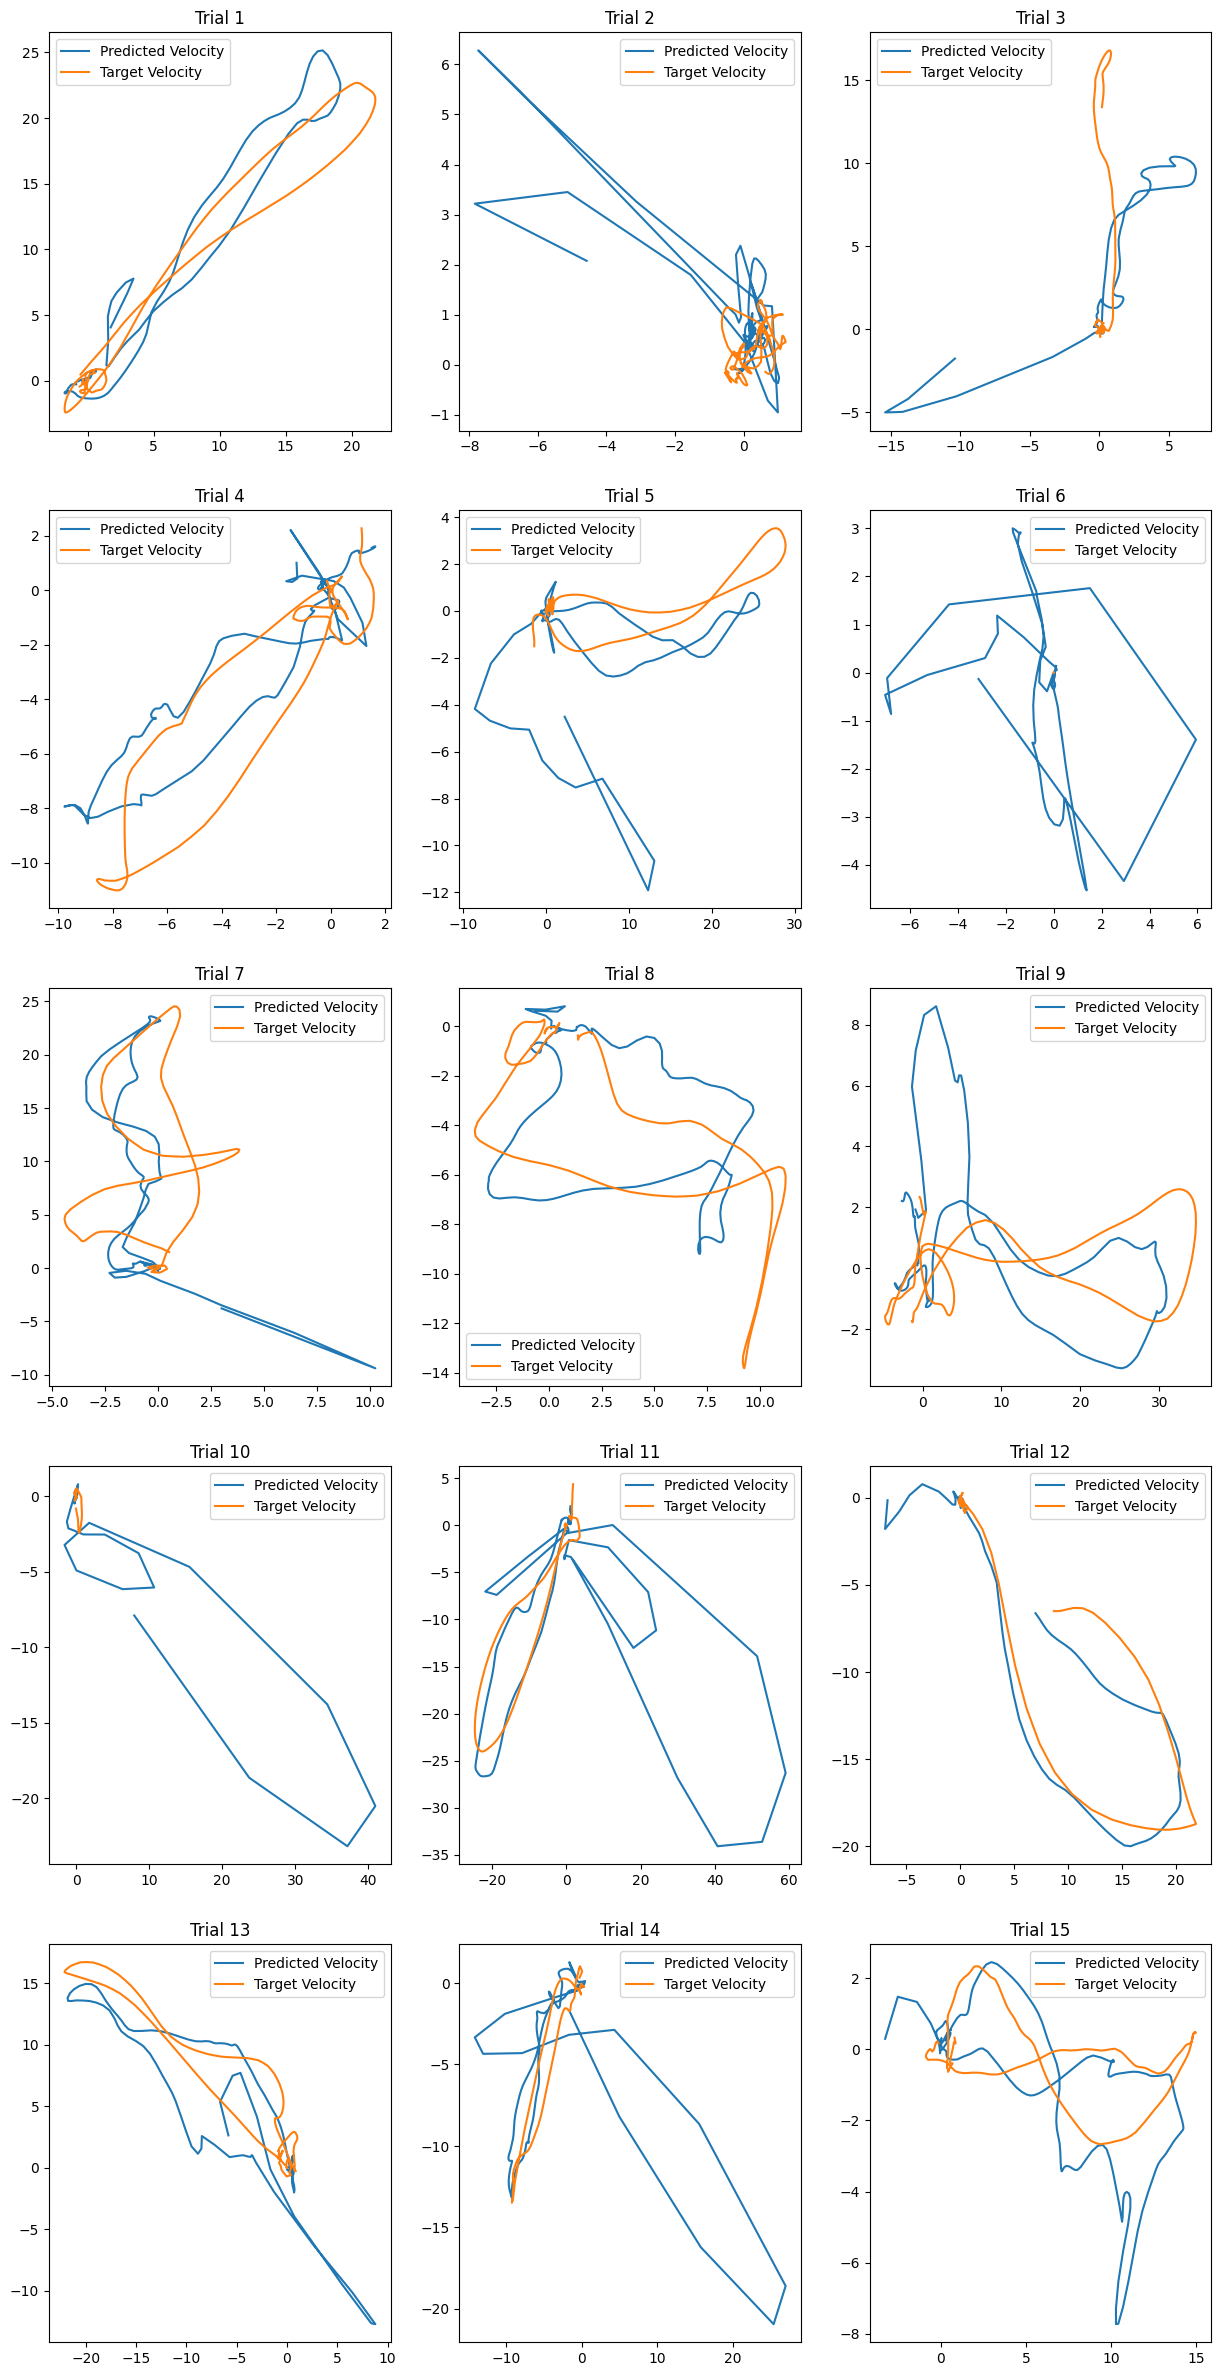

In [ ]:
import equinox as eqx
import jax
import numpy as np
inf_model = eqx.nn.inference_mode(model)
for batch in train_loader: 
    batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
    dataset_group_idxs = batch["dataset_group_idx"]
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    preds, state = jax.vmap(inf_model, axis_name="batch", in_axes=(0, None, 0, None), out_axes=(0, None))(inputs, state, dataset_group_idxs, jr.PRNGKey(0))
    break

c_co_targets = targets[dataset_group_idxs == 0]
c_co_preds = preds[dataset_group_idxs == 0] 

fig, axs = plt.subplots(5, 3, figsize=(15, 30))
axs = axs.flatten()
for i in range(15):
    pred = c_co_preds[i]
    target = c_co_targets[i]
    ax = axs[i] 
    ax.plot(pred[:, 0], pred[:, 1], label='Predicted Velocity')
    ax.plot(target[:, 0], target[:, 1], label='Target Velocity')
    ax.set_title(f"Trial {i+1}")
    ax.legend()